# Quick EDA

In [5]:
from scipy.io import loadmat
from PIL import Image

In [2]:
full = loadmat('emnist-byclass.mat') #pulling from file
data = full['dataset'] #this snags the particular set that I used
del full #for the sake of preserving RAM

In [3]:
data

array([[(array([[(array([[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[35],
                       [36],
                       [ 6],
                       ...,
                       [ 5],
                       [11],
                       [22]], dtype=uint8), array([[2376],
                       [3994],
                       [3699],
                       ...,
                       [  26],
                       [ 421],
                       [1243]], dtype=uint16))                             ]],
              dtype=[('images', 'O'), ('labels', 'O'), ('writers', 'O')]), array([[(array([[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
        

Hard to explain exactly what's going on with the structure of the dataset, but the relevant sets are as follows:

data[0][0][0][0][0][0] - These are the preallocated training data

data[0][0][0][0][0][1] - these are our training labels

data[0][0][1][0][0][0] - test data

data[0][0][1][0][0][1] - test labels

Let's take a quick look at what these images look like!


In [6]:
keyDict ={}
counter=0
for i in data[0][0][0][0][0][1]:
    if data[0][0][0][0][0][1][counter][0] not in keyDict.keys():
        #collList.append(counter)
        keyDict[data[0][0][0][0][0][1][counter][0]] = counter
    counter+=1
imDict={}
for i in keyDict.keys():
    imDict[i] = Image.fromarray(data[0][0][0][0][0][0][keyDict[i]].reshape((28,28)).T)

for i in sorted(imDict.keys()):
    display(imDict[i])

#this is a copy paste job from a different notebook, 
#please don't worry about the loops here- I'm sure they had a purpose at the time.
#but anyways, this should grab an example of each possible character and display the image

# Quick Baselines

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(data[0][0][0][0][0][0],data[0][0][0][0][0][1])
lr.score(data[0][0][1][0][0][0],data[0][0][1][0][0][1])

The above Logistic Regression model gave me an accuracy score of 0.7213018921451476. Took just north of 2.5 hours when I timed it

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(data[0][0][0][0][0][0],data[0][0][0][0][0][1])
knn.score(data[0][0][1][0][0][0],data[0][0][1][0][0][1])

#I tried scoring KNN on the full dataset for ~36 hours. It did not complete.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data[0][0][0][0][0][0],data[0][0][0][0][0][1], test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
#got 0.8226143853281116 first time I ran it- looking pretty good!
#also only took a half hour (note that this is a slightly abridged dataset, I just did a train/test split on 
#the training data instead of using the preallocated quantities. Choice to do so was somewhat arbitrary but I wanted
#to speed things up)

In [ ]:
#I also tried an XGBoost model, which performed well, but run time was far too long to be a serious consideration
#(even with a low dimensional PCA)
pca = decomposition.PCA(n_components=1)
X_train, X_test, y_train, y_test = train_test_split(train_arrs, train_labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='multi:softmax', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        num_classes=62
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='merror', #merror for multiclass error
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 



# PCA

Alright! Let's move on to tuning the PCA # of components and see where that lands us after a while!

In [ ]:
scores = []
for i in range(1,65):
    scaler = StandardScaler()
    pca = decomposition.PCA(n_components=i)
    X_train,X_test,y_train,y_test = train_test_split(train_arrs,train_labels, test_size=0.3)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    lr = LogisticRegression(max_iter=100000)
    lr.fit(X_train,y_train)
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    temp1=lr.score(X_test,y_test)
    temp2=dt.score(X_test,y_test)
    temp3=rf.score(X_test,y_test)
    print(temp1)
    print(temp2)
    print(temp3)
    print('break')
    scores.append(temp1)
    scores.append(temp2)
    scores.append(temp3)
    scores.append("End of this round, n="+str(i))

In [1]:
#Ignore this, I'm basically just recreating the results from a previous output
scores = [0.1331,0.0724,0.0724,0.20076666666666668,0.12126666666666666,0.15113333333333334,
 0.22606666666666667,0.15183333333333332,0.21646666666666667,0.2688333333333333,0.1952,0.2978,0.3238,
 0.2680666666666667,0.3953,0.36456666666666665,0.33376666666666666,0.48036666666666666,0.4076,0.38776666666666665,0.5486,
 0.4631,0.4402333333333333,0.6140333333333333,0.5032666666666666,0.4736,0.6523666666666667,0.5270333333333334,
 0.4845,0.6690333333333334,0.5543666666666667,0.49433333333333335,0.6842333333333334,0.5667,0.5020333333333333,
 0.6904333333333333,0.5774666666666667,0.4977,0.6953,0.5900666666666666,0.5058666666666667,0.7021333333333334,
 0.6031,0.5106,0.7105,0.6084333333333334,0.5115333333333333,0.7143666666666667,0.622,0.5118666666666667,0.7196333333333333,
 0.6229,0.5163,0.7235666666666667,0.6374333333333333,0.5145,0.7288333333333333,0.6383,0.5200666666666667,0.7230333333333333,
 0.6376666666666667,0.5158666666666667,0.725,0.6467333333333334,0.5135,0.7311333333333333,0.6503666666666666,0.5180333333333333,0.7314666666666667,
 0.6553333333333333,0.5168,0.7295,0.6552666666666667,0.5144333333333333,0.7302666666666666,0.6677666666666666,
 0.5187666666666667,
 0.7375666666666667,
 0.6632666666666667,
 0.5117666666666667,
 0.7310666666666666,
 0.6662666666666667,
 0.5173333333333333,
 0.7356666666666667,
 0.6693,
 0.5215666666666666,
 0.7327,
 0.6764,
 0.5202333333333333,
 0.7371,
 0.6720666666666667,
 0.5207666666666667,
 0.7331333333333333,
 0.6794666666666667,
 0.5205,
 0.7376,
 0.6805666666666667,
 0.5165333333333333,
 0.7369,
 0.6804333333333333,
 0.5123666666666666,
 0.7353666666666666,
 0.6856,
 0.5227,
 0.7381333333333333,
 0.6856333333333333,
 0.5173333333333333,
 0.7362,
 0.6831666666666667,
 0.5101666666666667,
 0.7357333333333334,
 0.6904,
 0.5213333333333333,
 0.7396,
 0.6937,
 0.5227333333333334,
 0.7401,
 0.6938,
 0.5167333333333334,
 0.7412666666666666,
 0.6913333333333334,
 0.5161,
 0.7375,
 0.6943333333333334,
 0.5118666666666667,
 0.7381333333333333,
 0.6937666666666666,
 0.5108333333333334,
 0.7396666666666667,
 0.6936333333333333,
 0.5175333333333333,
 0.7356333333333334,
 0.6939333333333333,
 0.5141,
 0.7358333333333333,
 0.6848,
 0.5167666666666667,
 0.7297666666666667,
 0.6952333333333334,
 0.5226333333333333,
 0.7364666666666667,
 0.6941666666666667,
 0.5158333333333334,
 0.7327,
 0.6961333333333334,
 0.5122666666666666,
 0.7330333333333333,
 0.7016,
 0.5146666666666667,
 0.7368,
 0.6971333333333334,
 0.5121333333333333,
 0.7347666666666667,
 0.6994333333333334,
 0.5090666666666667,
 0.7339,
 0.6976333333333333,
 0.5111333333333333,
 0.7337666666666667,
 0.6975,
 0.5119,
 0.7332333333333333,
 0.7012666666666667,
 0.5100333333333333,
 0.7335666666666667,
 0.7002333333333334,
 0.5129666666666667,
 0.7323333333333333,
 0.7018,
 0.5122333333333333,
 0.7333666666666666,
 0.6999,
 0.5081333333333333,
 0.7303,
 0.7057,
 0.5087333333333334,
 0.7351,
 0.6991,
 0.5062333333333333,
 0.7278333333333333,
 0.7034333333333334,
 0.5113,
 0.7327666666666667,
 0.7065,
 0.5133666666666666,
 0.7341333333333333,
 0.7037,
 0.5031,
 0.7322333333333333,
 0.7068,
 0.5103666666666666,
 0.7304333333333334,
 0.7028,
 0.509,
 0.7268]
lrList=[]
dtList=[]
rfList=[]
count = 0
for i in scores:
    if count==0:
        lrList.append(i)
    elif count==1:
        dtList.append(i)
    elif count==2:
        rfList.append(i)
    count+=1
    if count==3:
        count=0

In [2]:
import matplotlib.pyplot as plt

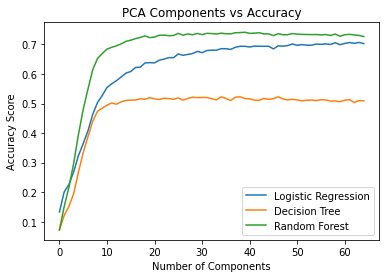

In [3]:
plt.plot(range(0,65),lrList, label = 'Logistic Regression')
plt.plot(range(0,65),dtList, label = 'Decision Tree')
plt.plot(range(0,65),rfList, label = 'Random Forest')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('PCA Components vs Accuracy')
plt.legend();

So looks like in general, Random Forest performs the best (at least, without any tuning on any of these), and it seems to cap out roughly around n=20, so let's just kinda run with that!

# Tuning RF Hyperparameters

I spent a fair amount of time fiddling around with the hyperparameters for random forest, and a lot of that is now lost, but I'm including here an example approach using RandomizedSearchCV

Also, note that I didn't actually use a pipeline in this case, as I really wasn't sure on how to best approach it here. As a result, I had to perform the PCA transform on the data AHEAD of running it through the search CV. This is obviously inappropriate, in essence you're having your test data interfere with your training, but alas I wasn't too sure how to best apply a pipeline such that, within the search CV, it would create and apply a PCA from JUST the training data, and not the validation and test data additionally.

In [ ]:
scaler = StandardScaler()
train_arrs = scaler.fit_transform(train_arrs)
pca = decomposition.PCA(n_components=20)
pca.fit(train_arrs)
train_arrs = pca.transform(train_arrs)

In [ ]:
max_depth = [int(x) for x in np.linspace(90, 150, num = 5)]
max_depth.append(None)
max_features= ['auto','sqrt']
#bootstrap = [True, False]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 4)]

model_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth':max_depth
    #'bootstrap':bootstrap
}

In [ ]:
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (50 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=10, cv=5, random_state=1)
#generally was forced to use a low iteration count just due to run-time.

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X, y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

print(model.best_estimator_.score)

# A quick look into feature selection

I also went the route of testing out a feature SELECTION approach. I used SKLearn's built in mutual information package to get a ranking of feature importance and then ran those (with increasing number of features) through random forest as well:

In [ ]:
train_arrs = data[0][0][0][0][0][0]
train_labels = data[0][0][0][0][0][1]
mi = mutual_info_classif(train_arrs,train_labels)
mi

In [ ]:
np.argsort(mi) #gives ascending
indexList= np.argsort(mi).reverse()

In [ ]:
toColumns = list(zip(*train_arrs)) #row to column swap, makes it easier to actually snag the columns of data
scores=[]
for i in range(2,65):
    #need to snag the appropriate features
    count=1
    data = np.array(toColumns[indexList[0]])
    while count<i:   
        data = np.column_stack((data,np.array(toColumns[indexList[count]]).reshape(len(toColumns[i]),1)))
        count+=1
    #then do the modeling
    X_train,X_test,y_train,y_test = train_test_split(data,train_labels, test_size=0.3)
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    temp = rf.score(X_test,y_test)
    print(temp)
    scores.append(temp)
#this is actually a lot more complicated than it looks
#anyways, this isn't nearly as good as PCA, when i ran it I got 
#0.5948 accuracy for n_features = 65